# Predicting bike rentals

Many American cities have communal bike-sharing stations where you can rent bicycles by the hour or day. Washington, D.C. collects detailed data about these rentals. This project aims to predict the total number of bikes people rented in a given hour. We will use a [dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) compiled by Hadi Fanaee-T at the [University of Porto](http://www.up.pt/).

## Data overview

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Import the dataset
bike_rentals = pd.read_csv("bike_rental_hour.csv", parse_dates=['dteday'])
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

Text(0, 0.5, 'Frequency')

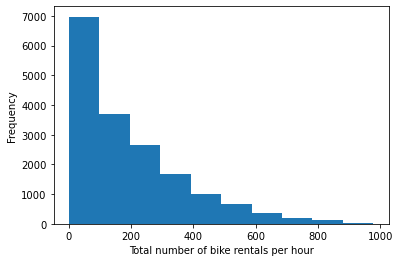

In [4]:
# Histogram of the total number of bike rentals
plt.hist(bike_rentals['cnt'])
plt.xlabel("Total number of bike rentals per hour")
plt.ylabel("Frequency")

In [5]:
# See how each column is correlated with cnt
correlation = bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)[1:]
correlation

registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

The columns `registered` and `casual` have a high correlation with `cnt` because the latter results from adding the former two columns.

## Feature engineering

In [6]:
def assign_label (hour):

    if hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3
    else:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.sample(5, random_state=0)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
3439,3440,2011-05-28,2,0,5,5,0,6,0,1,0.56,0.5303,0.88,0.2239,4,3,7,4
6542,6543,2011-10-05,4,0,10,4,0,3,1,1,0.44,0.4394,0.88,0.0000,1,4,5,4
15470,15471,2012-10-11,4,1,10,19,0,4,1,1,0.44,0.4394,0.51,0.1343,81,662,743,3
9851,9852,2012-02-20,1,1,2,11,1,1,0,1,0.26,0.2273,0.48,0.3582,45,163,208,1
12640,12641,2012-06-15,2,1,6,21,0,5,1,1,0.66,0.6212,0.50,0.1045,83,250,333,3


## Training and testing

We will split the dataset into training and testing sets. We will use the Root Mean Square Error (RMSE) metric to evaluate the performance of the machine learning algorithms. This metric works well on continuous numeric data.

In [7]:
np.random.seed(1)

n_row = bike_rentals.shape[0]

idx = np.random.permutation(n_row)

k_row = int(np.round(0.8 * n_row))

train = bike_rentals.iloc[idx[:k_row]]
test = bike_rentals.iloc[idx[k_row:]]

## Linear regression model

We will now fit a linear regression model to the data. This model will probably work reasonably well on this data, given that many of the columns have a good correlation with `cnt`. As we mentioned before, the column `cnt` is obtained by adding the columns `registered` and `casual`. The latter columns will not be used as features. We will also exclude the column `dteday`.

In [8]:
target = 'cnt'

features = correlation.index.drop(['registered','casual']).values
features

array(['temp', 'atemp', 'hr', 'hum', 'instant', 'yr', 'season',
       'weathersit', 'mnth', 'windspeed', 'holiday', 'workingday',
       'weekday'], dtype=object)

In [9]:
lr = LinearRegression()

lr.fit(train[features], train[target])

predictions = lr.predict(test[features])

rmse = np.sqrt(mean_squared_error(test[target], predictions))
rmse

139.93117790704292

In [10]:
# Average number of bike rentals per hour
bike_rentals['cnt'].mean()

189.46308763450142

The RMSE is 130.8. Since the average number of bike rentals per hour is 189, the obtained RMSE is high. The RMSE penalizes large errors. As observed in the histogram, the column ‘cnt’ has a few extreme values, which might explain the high RMSE.

## Decision tree model

We will now fit a decision tree regressor to the data. Decision trees tend to predict outcomes more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit if we don’t tune some parameters. We will first use the default values and after we will experiment with different values of `min_samples_split` and `max_depth`. `min_samples_split` is the minimum number of samples required to split an internal node, and `max_depth` is the maximum depth of the tree.

In [11]:
dtr = DecisionTreeRegressor()

dtr.fit(train[features], train[target])

predictions = dtr.predict(test[features])

rmse = np.sqrt(mean_squared_error(test[target], predictions))

print("The RMSE is {:.1f} and the tree depth is {}.".format(rmse, dtr.tree_.max_depth))

The RMSE is 57.0 and the tree depth is 34.


In [12]:
def train_test_dtr(min_samples_split, max_depth):

    dtr = DecisionTreeRegressor(min_samples_leaf=min_samples_split, max_depth=max_depth)

    dtr.fit(train[features], train[target])

    predictions = dtr.predict(test[features])

    return np.sqrt(mean_squared_error(test[target], predictions))

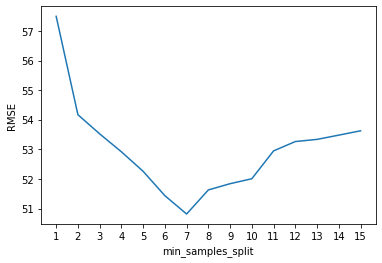

In [13]:
min_samples_split = range(1,16)

rmses = [train_test_dtr(i, 25) for i in min_samples_split]

plt.plot(min_samples_split, rmses)
plt.xticks(min_samples_split)
plt.xlabel("min_samples_split")
plt.ylabel("RMSE");

The minimum RMSE is obtained when we considered `min_samples_split` equal to 8.

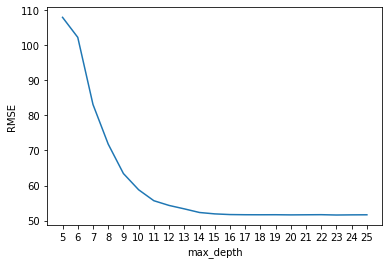

In [14]:
max_depth = range(5,26)

rmses = [train_test_dtr(8, i) for i in max_depth]

plt.plot(max_depth, rmses)
plt.xticks(max_depth)
plt.xlabel("max_depth")
plt.ylabel("RMSE");

The error decreases with the increase of the maximum depth of the tree until a depth of 14. After that, the error remains constant, and so there is no point of increasing the complexity of the model.

In [15]:
print("The RMSE is {:.1f} for min_samples_split=8 and max_depth=14.".format(rmses[9]))

The RMSE is 52.3 for min_samples_split=8 and max_depth=14.


## Random forest model

We will now fit a random forest regressor to the data. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's essential to tune parameters like maximum depth and minimum samples per leaf.

In [16]:
rfr = RandomForestRegressor()

rfr.fit(train[features], train[target])

predictions = rfr.predict(test[features])

rmse = np.sqrt(mean_squared_error(test[target], predictions))

print("The RMSE is {:.1f}.".format(rmse))

The RMSE is 42.7.


In [17]:
def train_test_dtr(min_samples_split, max_depth):

    rfr = RandomForestRegressor(min_samples_leaf=min_samples_split, max_depth=max_depth)

    rfr.fit(train[features], train[target])

    predictions = rfr.predict(test[features])

    return np.sqrt(mean_squared_error(test[target], predictions))

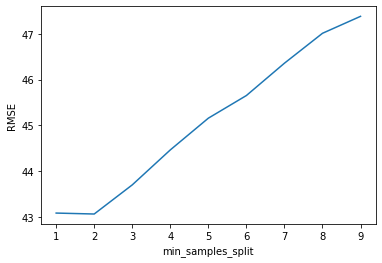

In [18]:
min_samples_split = range(1,10)

rmses = [train_test_dtr(i, 25) for i in min_samples_split]

plt.plot(min_samples_split, rmses)
plt.xticks(min_samples_split)
plt.xlabel("min_samples_split")
plt.ylabel("RMSE");

The minimum RMSE is obtained when we considered `min_samples_split` equal to 1 (default value).

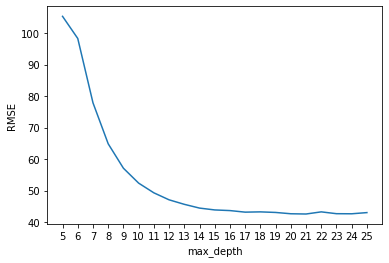

In [19]:
max_depth = range(5,26)

rmses = [train_test_dtr(1, i) for i in max_depth]

plt.plot(max_depth, rmses)
plt.xticks(max_depth)
plt.xlabel("max_depth")
plt.ylabel("RMSE");

In [20]:
print("The RMSE is {:.1f} for min_samples_split=1 and max_depth=21.".format(rmses[16]))

The RMSE is 42.6 for min_samples_split=1 and max_depth=21.


## Conclusions

The random forests models proved to be the most accurate ones. The following table shows the minimum RMSE obtained with each method.

Method | RMSE
--- | ---
Linear regression | 189.5
Decision tree | 51.3
Random forest | 40.5